In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import h5py

# Import Tensorflow
import tensorflow as tf
import tensorflow.keras.backend as K
from tensorflow.keras import optimizers, losses, activations, models, initializers, regularizers, constraints
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, LearningRateScheduler, ReduceLROnPlateau
from tensorflow.keras.layers import Layer, Dense, Input, Dropout, Convolution1D, Conv1D, MaxPool1D, GlobalMaxPool1D, GlobalAveragePooling1D, \
    concatenate, BatchNormalization, Bidirectional, LSTM, Flatten, Permute, Concatenate, Reshape
from tensorflow.keras.models import load_model, Model, Sequential
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_addons as tfa

# Import Sklearn
from sklearn.metrics import f1_score, accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight

# custom modules
from utils import *
from cf_matrix import *
from data import get_tsfel_features


from livelossplot import PlotLossesKeras

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
os.environ["CUDA_VISIBLE_DEVICES"]="1" # select GPU

In [4]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


## MITBIH Model

In [5]:
WINDOW_SIZE = 187
NO_CLASSES = 5
SAMPLING_RATE = 125.0

INPUT_SHAPE = (WINDOW_SIZE, 1, 1)

### Load data

In [6]:
df_train = pd.read_csv("./data/mitbih_train.csv", header=None)
df_train = df_train.sample(frac=1, random_state=42)
df_test = pd.read_csv("./data/mitbih_test.csv", header=None)

Y = np.array(df_train[187].values).astype(np.int8)
X = np.array(df_train[list(range(187))].values)[..., np.newaxis]

Y_test = np.array(df_test[187].values).astype(np.int8)
X_test = np.array(df_test[list(range(187))].values)[..., np.newaxis]

In [7]:
X = X.reshape((X.shape[0], WINDOW_SIZE, 1, 1))
X_test = X_test.reshape((X_test.shape[0], WINDOW_SIZE, 1, 1))

In [8]:
print("Train", X.shape, Y.shape)
print("Test", X_test.shape, Y_test.shape)

Train (87554, 187, 1, 1) (87554,)
Test (21892, 187, 1, 1) (21892,)


### Class weights

In [9]:
cls_weights = class_weight.compute_class_weight('balanced', classes = np.unique(Y),  y = Y)
cls_weight_dict = dict(enumerate(cls_weights))

## Patch based Transformer
Adapted from https://keras.io/examples/vision/image_classification_with_vision_transformer/

#### Configure Hyperparameters

In [10]:
learning_rate = 0.001
weight_decay = 0.0001
batch_size = 256
num_epochs = 100
image_size = WINDOW_SIZE  # We'll resize input images to this size
patch_size = 6  # Size of the patches to be extract from the input images
num_patches = (image_size // patch_size)
projection_dim = 64
num_heads = 5
transformer_units = [
    projection_dim * 2,
    projection_dim,
]  # Size of the transformer layers
transformer_layers = 3
mlp_head_units = [512, 256]  # Size of the dense layers of the final classifier

weight_file_path = "./models/patch_transfomer_mitbih.h5"
weight_file_path_ptb = "./models/patch_transfomer_ptb.h5"

#### Data Augmentation

In [11]:
# Noise Layer:
# https://stackoverflow.com/questions/58484545/how-to-add-a-noise-with-uniform-distribution-to-input-data-in-keras
class noiseLayer(tf.keras.layers.Layer):

    def __init__(self,mean,std):
        super(noiseLayer, self).__init__()
        self.mean = mean
        self.std  = std
        
    # TODO: implement reasonably
    def get_config(self):
        return {}

    def call(self, input):

        mean = self.mean
        std  = self.std
        
        res = input + tf.random.normal(tf.shape(input), mean = mean, stddev = std)

        return res

In [12]:
data_augmentation = keras.Sequential(
    [
        layers.experimental.preprocessing.Normalization(),
        noiseLayer(mean = 0, std = 0.05)
    ],
    name="data_augmentation",
)
# Compute the mean and the variance of the training data for normalization.
data_augmentation.layers[0].adapt(X)

#### MLP

In [13]:
def mlp(x, hidden_units, dropout_rate):
    for units in hidden_units:
        x = layers.Dense(units, activation=tf.nn.gelu)(x)
        x = layers.Dropout(dropout_rate)(x)
    return x

#### Patch Creation Layer

In [14]:
class Patches(layers.Layer):
    def __init__(self, patch_size):
        super(Patches, self).__init__()
        self.patch_size = patch_size
        
    # TODO: implement reasonably
    def get_config(self):
        return {}

    def call(self, images):
        batch_size = tf.shape(images)[0]
        patches = tf.image.extract_patches(
            images=images,
            sizes=[1, self.patch_size, 1, 1],
            strides=[1, self.patch_size, 1, 1],
            rates=[1, 1, 1, 1],
            padding="VALID",
        )
        patch_dims = patches.shape[-1]
        patches = tf.reshape(patches, [batch_size, -1, patch_dims])
        return patches

#### Patch Encoding Layer

In [15]:
class PatchEncoder(layers.Layer):
    def __init__(self, num_patches, projection_dim):
        super(PatchEncoder, self).__init__()
        self.num_patches = num_patches
        self.projection = layers.Dense(units=projection_dim)
        self.position_embedding = layers.Embedding(
            input_dim=num_patches, output_dim=projection_dim
        )
        
    # TODO: implement reasonably
    def get_config(self):
        return {}

    def call(self, patch):
        positions = tf.range(start=0, limit=self.num_patches, delta=1)
        encoded = self.projection(patch) + self.position_embedding(positions)
        return encoded

#### Build Transfomer

In [16]:
def create_transfomer_classifier():
    
    inputs = layers.Input(shape=INPUT_SHAPE)
    # Augment data.
    augmented = data_augmentation(inputs)
    # Create patches.
    patches = Patches(patch_size)(augmented)
    # Encode patches.
    encoded_patches = PatchEncoder(num_patches, projection_dim)(patches)

    # Create multiple layers of the Transformer block.
    for _ in range(transformer_layers):
        # Layer normalization 1.
        x1 = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
        # Create a multi-head attention layer.
        attention_output = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=projection_dim, dropout=0.1
        )(x1, x1)
        # Skip connection 1.
        x2 = layers.Add()([attention_output, encoded_patches])
        # Layer normalization 2.
        x3 = layers.LayerNormalization(epsilon=1e-6)(x2)
        # MLP.
        x3 = mlp(x3, hidden_units=transformer_units, dropout_rate=0.1)
        # Skip connection 2.
        encoded_patches = layers.Add()([x3, x2])

    # Create a [batch_size, projection_dim] tensor.
    representation = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
    representation = layers.Flatten()(representation)
    representation = layers.Dropout(0.5)(representation)
    # Add MLP.
    features = mlp(representation, hidden_units=mlp_head_units, dropout_rate=0.5)
    # Classify outputs.
    logits = layers.Dense(NO_CLASSES, activation="softmax")(features)
    # Create the Keras model.
    model = keras.Model(inputs=inputs, outputs=logits)
    
    return model

### Training

In [18]:
def run_experiment(model):
    optimizer = tfa.optimizers.AdamW(
        learning_rate=learning_rate, weight_decay=weight_decay
    )
    
    min_lr           = 0.00005 # 0.00005
    reduce_lr_factor = 0.5     # 0.8
    patience         = 5
    cooldown         = 5 
    
    monitor = "val_accuracy" # val_accuracy
    mode = "max" # max
    checkpoint = ModelCheckpoint(
        weight_file_path,
        monitor=monitor,
        verbose=1,
        save_best_only=True,
        mode=mode
    )
    early = EarlyStopping(
        monitor=monitor,
        mode=mode,
        patience=8,
        verbose=1
    )
    redonplat = ReduceLROnPlateau(
        monitor=monitor,
        mode=mode,
        factor=reduce_lr_factor,
        patience=patience,
        cooldown=cooldown,
        min_lr=min_lr,
        verbose=2
    )

    callbacks_list = [checkpoint, early, redonplat] # PlotLossesKeras()
    
    model.compile(
        optimizer=optimizer,
        loss=keras.losses.SparseCategoricalCrossentropy(),
        metrics=[
            keras.metrics.SparseCategoricalAccuracy(name="accuracy"),
        ],
    )



    history = model.fit(
        x=X,
        y=Y,
        batch_size=batch_size,
        epochs=num_epochs,
        validation_split=0.1,
        callbacks=callbacks_list,
    )

    model.load_weights(weight_file_path)
    _, accuracy = model.evaluate(X_test, Y_test)
    print(f"Test accuracy: {round(accuracy * 100, 2)}%")

    return history

In [19]:
# Create model
transfomer_classifier = create_transfomer_classifier()

In [62]:
# transfomer_classifier.summary()
# tf.keras.utils.plot_model(transfomer_classifier, show_shapes=True)

In [21]:
# Train
history = run_experiment(transfomer_classifier)

Epoch 1/100
308/308 [==============================] - 10s 22ms/step - loss: 0.6294 - accuracy: 0.8410 - val_loss: 0.1703 - val_accuracy: 0.9518

Epoch 00001: val_loss improved from inf to 0.17030, saving model to ./models/patch_transfomer_mitbih.h5
Epoch 2/100
308/308 [==============================] - 6s 20ms/step - loss: 0.2322 - accuracy: 0.9396 - val_loss: 0.1209 - val_accuracy: 0.9655

Epoch 00002: val_loss improved from 0.17030 to 0.12086, saving model to ./models/patch_transfomer_mitbih.h5
Epoch 3/100
308/308 [==============================] - 6s 19ms/step - loss: 0.1740 - accuracy: 0.9532 - val_loss: 0.1149 - val_accuracy: 0.9727

Epoch 00003: val_loss improved from 0.12086 to 0.11494, saving model to ./models/patch_transfomer_mitbih.h5
Epoch 4/100
308/308 [==============================] - 6s 19ms/step - loss: 0.1463 - accuracy: 0.9597 - val_loss: 0.0959 - val_accuracy: 0.9751

Epoch 00004: val_loss improved from 0.11494 to 0.09586, saving model to ./models/patch_transfomer_m

308/308 [==============================] - 6s 18ms/step - loss: 0.0406 - accuracy: 0.9869 - val_loss: 0.0411 - val_accuracy: 0.9881

Epoch 00036: val_loss improved from 0.04419 to 0.04112, saving model to ./models/patch_transfomer_mitbih.h5
Epoch 37/100
308/308 [==============================] - 6s 18ms/step - loss: 0.0327 - accuracy: 0.9887 - val_loss: 0.0469 - val_accuracy: 0.9871

Epoch 00037: val_loss did not improve from 0.04112
Epoch 38/100
308/308 [==============================] - 6s 19ms/step - loss: 0.0320 - accuracy: 0.9894 - val_loss: 0.0430 - val_accuracy: 0.9887

Epoch 00038: val_loss did not improve from 0.04112
Epoch 39/100
308/308 [==============================] - 6s 19ms/step - loss: 0.0326 - accuracy: 0.9891 - val_loss: 0.0436 - val_accuracy: 0.9888

Epoch 00039: val_loss did not improve from 0.04112
Epoch 40/100
308/308 [==============================] - 6s 18ms/step - loss: 0.0295 - accuracy: 0.9907 - val_loss: 0.0470 - val_accuracy: 0.9879

Epoch 00040: val_loss 

### Evaluation

In [27]:
# load best model
transfomer_classifier.load_weights(weight_file_path)

f1 score micro:           0.98502
f1 score macro:           0.91565
accuracy score:           0.98502
balanced accuracy score:  0.89386


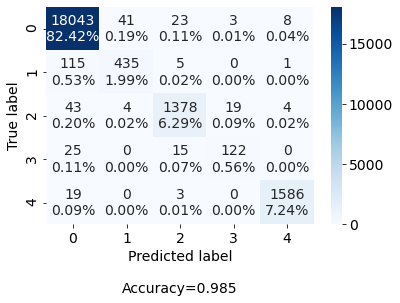

In [28]:
pred_test_proba = transfomer_classifier.predict(X_test)
pred_test = np.argmax(pred_test_proba, axis=-1)

# print("F1 Macro:", f1_score(Y_test, pred_test, average="macro"))
display_result(Y_test, pred_test)

In [29]:
np.save("./predictions/test_mitbih_patch_transfomer", pred_test, allow_pickle=True)
np.save("./predictions/test_mitbih_proba_patch_transfomer", pred_test_proba, allow_pickle=True)

In [30]:
pred_test_proba = transfomer_classifier.predict(X)
pred_test = np.argmax(pred_test_proba, axis=-1)
np.save("./predictions/train_mitbih_patch_transfomer", pred_test, allow_pickle=True)
np.save("./predictions/train_mitbih_proba_patch_transfomer", pred_test_proba, allow_pickle=True)

# PTB

#### Load data

In [28]:
df_1_ptb = pd.read_csv("./data/ptbdb_normal.csv", header=None)
df_2_ptb = pd.read_csv("./data/ptbdb_abnormal.csv", header=None)
df_ptb = pd.concat([df_1_ptb, df_2_ptb])

df_train_ptb, df_test_ptb = train_test_split(df_ptb, test_size=0.2, random_state=1337, stratify=df_ptb[187])


Y_ptb = np.array(df_train_ptb[187].values).astype(np.int8)
X_ptb = np.array(df_train_ptb[list(range(187))].values)[..., np.newaxis]

Y_test_ptb = np.array(df_test_ptb[187].values).astype(np.int8)
X_test_ptb = np.array(df_test_ptb[list(range(187))].values)[..., np.newaxis]

In [29]:
X_ptb = X_ptb.reshape((X_ptb.shape[0], WINDOW_SIZE, 1, 1))
X_test_ptb = X_test_ptb.reshape((X_test_ptb.shape[0], WINDOW_SIZE, 1, 1))

In [30]:
print("Train", X_ptb.shape, Y_ptb.shape)
print("Test", X_test_ptb.shape, Y_test_ptb.shape)

Train (11641, 187, 1, 1) (11641,)
Test (2911, 187, 1, 1) (2911,)


#### Training

In [45]:
TRANSFER = True # configure to use transfer learning or not

In [46]:
# Create raw model
transfomer_classifier_ptb_raw = create_transfomer_classifier()

In [47]:
opt_ptb = optimizers.Adam(0.001)
transfomer_classifier_ptb_raw.compile(optimizer=opt_ptb, loss=losses.sparse_categorical_crossentropy, metrics=['acc'])
# model.summary()

In [48]:
# Load weights from MITBIH for transfer learning (comment out if training purely)
if TRANSFER:
    print("Loading pretrained weights from MITBIH dataset")
    transfomer_classifier_ptb_raw.load_weights(weight_file_path)

Loading pretrained weights from MITBIH dataset


In [49]:
# Adapting normalization layer to new data
transfomer_classifier_ptb_raw.layers[1].layers[0].adapt(X_ptb)

In [50]:
new_out = Dense(1, activation=activations.sigmoid, name="ptb_sigmoid")(transfomer_classifier_ptb_raw.layers[-2].output)

transfomer_classifier_ptb = Model(inputs=transfomer_classifier_ptb_raw.input, outputs=new_out)
# transfomer_classifier_ptb.summary()

In [51]:
def run_experiment_ptb(model):
    optimizer = tfa.optimizers.AdamW(
        learning_rate=learning_rate, weight_decay=weight_decay
    )
    
    min_lr           = 0.00005 # 0.00005
    reduce_lr_factor = 0.5     # 0.8
    patience         = 5
    cooldown         = 5 
    
    monitor = "val_acc" # val_accuracy
    mode = "max" # max
    checkpoint = ModelCheckpoint(
        weight_file_path_ptb,
        monitor=monitor,
        verbose=1,
        save_best_only=True,
        mode=mode
    )
    early = EarlyStopping(
        monitor=monitor,
        mode=mode,
        patience=8,
        verbose=1
    )
    redonplat = ReduceLROnPlateau(
        monitor=monitor,
        mode=mode,
        factor=reduce_lr_factor,
        patience=patience,
        cooldown=cooldown,
        min_lr=min_lr,
        verbose=2
    )

    callbacks_list = [checkpoint, early, redonplat] # PlotLossesKeras()
    
    model.compile(
        optimizer=optimizer,
        loss=losses.BinaryCrossentropy(),
        metrics=["acc"],
    )



    history = model.fit(
        x=X_ptb,
        y=Y_ptb,
        batch_size=batch_size,
        epochs=num_epochs,
        validation_split=0.1,
        callbacks=callbacks_list,
    )

    model.load_weights(weight_file_path_ptb)
    _, accuracy = model.evaluate(X_test_ptb, Y_test_ptb)
    print(f"Test accuracy: {round(accuracy * 100, 2)}%")

    return history

#### Fitting

In [ ]:
history = run_experiment_ptb(transfomer_classifier_ptb)

### Evaluation

In [58]:
# load best model
transfomer_classifier_ptb.load_weights(weight_file_path_ptb)

f1 score micro:           0.99038
f1 score macro:           0.98798
accuracy score:           0.99038
balanced accuracy score:  0.9865
AuPR score:               0.99786
AuROC score:              0.99688


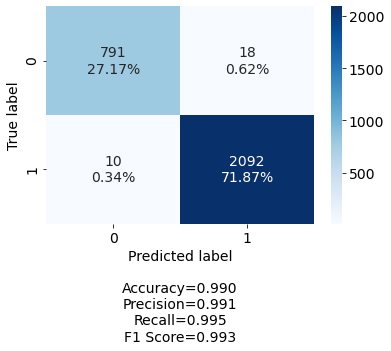

In [59]:
pred_test_proba = transfomer_classifier_ptb.predict(X_test_ptb)
pred_test = [1 if x > 0.5 else 0 for x in pred_test_proba]

# print("F1 Macro:", f1_score(Y_test, pred_test, average="macro"))
display_result(Y_test_ptb, pred_test, curve=True, proba=pred_test_proba)

In [60]:
transfer_str = "_transfer" if TRANSFER else ""

In [61]:
np.save(f"./predictions/test_ptb_patch_transfomer{transfer_str}", pred_test, allow_pickle=True)
np.save(f"./predictions/test_ptb_proba_patch_transfomer{transfer_str}", pred_test_proba, allow_pickle=True)

In [62]:
pred_test_proba = transfomer_classifier_ptb.predict(X_ptb)
pred_test = [1 if x > 0.5 else 0 for x in pred_test_proba]
np.save(f"./predictions/train_ptb_patch_transfomer{transfer_str}", pred_test, allow_pickle=True)
np.save(f"./predictions/train_ptb_proba_patch_transfomer{transfer_str}", pred_test_proba, allow_pickle=True)